In [1]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
benign_path = '/content/drive/MyDrive/Colab Notebooks/project_NTI/Dataset_BUSI_with_GT/benign'
normal_path = '/content/drive/MyDrive/Colab Notebooks/project_NTI/Dataset_BUSI_with_GT/normal'
malignant_path = '/content/drive/MyDrive/Colab Notebooks/project_NTI/Dataset_BUSI_with_GT/malignant'

In [4]:
images = []
labels = []

In [5]:
def load_images_and_labels(path, label):
    for filename in os.listdir(path):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img = cv2.imread(os.path.join(path, filename))
            img = cv2.resize(img, (128, 128))
            images.append(img)
            labels.append(label)

In [6]:
load_images_and_labels(benign_path, 0)
load_images_and_labels(normal_path, 1)
load_images_and_labels(malignant_path, 2)

In [7]:
images = np.array(images)
labels = np.array(labels)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import *
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [10]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

9406464/9406464 [==============================] - 1s 0us/step


In [13]:
tf.keras.applications.ResNet152V2(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

242745792/242745792 [==============================] - 8s 0us/step


In [14]:
model = tf.keras.Sequential([
    Conv2D(128, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
train_generator = datagen.flow(X_train, y_train, batch_size=32)
history = model.fit(train_generator, epochs=100, validation_data=(X_test, y_test),callbacks=[early_stopping])

Epoch 1/100
40/40 [==============================] - 19s 167ms/step - loss: 5.5449 - accuracy: 0.4905 - val_loss: 0.9180 - val_accuracy: 0.5791
Epoch 2/100
40/40 [==============================] - 8s 199ms/step - loss: 0.8976 - accuracy: 0.6022 - val_loss: 0.8082 - val_accuracy: 0.6962
Epoch 3/100
40/40 [==============================] - 6s 146ms/step - loss: 0.8445 - accuracy: 0.6307 - val_loss: 0.7791 - val_accuracy: 0.6962
Epoch 4/100
40/40 [==============================] - 8s 202ms/step - loss: 0.7921 - accuracy: 0.6434 - val_loss: 0.7512 - val_accuracy: 0.6994
Epoch 5/100
40/40 [==============================] - 6s 144ms/step - loss: 0.7905 - accuracy: 0.6521 - val_loss: 0.7279 - val_accuracy: 0.7025
Epoch 6/100
40/40 [==============================] - 8s 199ms/step - loss: 0.7676 - accuracy: 0.6585 - val_loss: 0.7443 - val_accuracy: 0.6930
Epoch 7/100
40/40 [==============================] - 7s 176ms/step - loss: 0.7642 - accuracy: 0.6379 - val_loss: 0.6830 - val_accuracy: 0.721

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 63, 63, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 conv2d_2 (Conv2D)           (None, 59, 59, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 29, 29, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 53824)             0

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Accuracy on test set:", test_accuracy)

10/10 [==============================] - 0s 14ms/step - loss: 0.4614 - accuracy: 0.7911
Accuracy on test set: 0.7911392450332642


In [20]:
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

10/10 [==============================] - 0s 12ms/step


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.97      0.85       191
           1       1.00      0.54      0.70        54
           2       0.86      0.51      0.64        71

    accuracy                           0.79       316
   macro avg       0.87      0.67      0.73       316
weighted avg       0.82      0.79      0.78       316



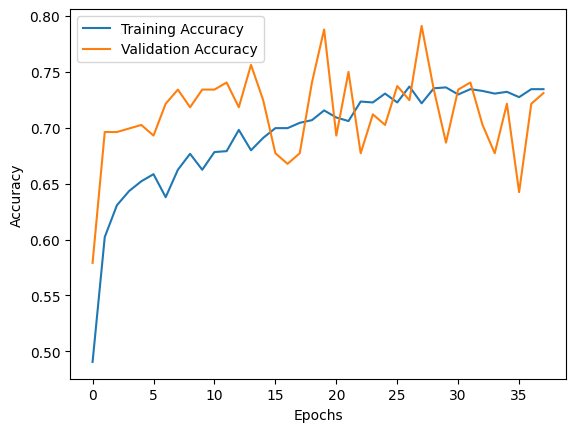

In [22]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

In [24]:
cm = confusion_matrix(y_test, y_pred)
classes = ['benign', 'normal',"malignant"]

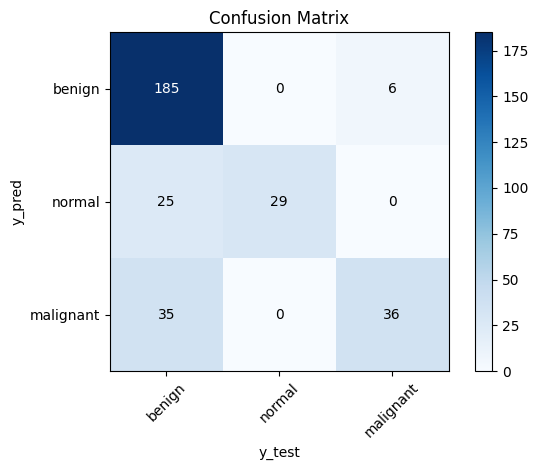

In [25]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'), ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

plt.xlabel('y_test')
plt.ylabel('y_pred')
plt.tight_layout()
plt.show()

In [26]:
model.save('breast_cancer_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# from google.colab import files

# files.download('breast_cancer_model.h5')